In [1]:

import argparse
import json
import os
import time
import numpy as np
from math import floor
from shutil import copy2
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing as mp
import torch.distributed as dist
# self-defined module
from utils.helper import init_DDP, Logger, print_log, load_labels, build_model
from utils.data import dataloader
from utils.train_model import train_model
from utils.test_model import test_model
import numpy as np
from math import floor
import os
import argparse
import torch
from torch.optim import Adam
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing as mp
# self-defined modules
from utils.helper import init_DDP, load_labels, build_model
from utils.data import dataloader
from utils.loss import calculate_loss
try:
    from torch_lr_finder import LRFinder
except ImportError:
    # Run from source
    import sys
    sys.path.insert(0, '..')
    from torch_lr_finder import LRFinder


/home/lingjia/anaconda3/envs/deepstorm3d/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser(description='3d localization')
# phase
parser.add_argument('--train_or_test', type=str, default='other', help='train or test')
parser.add_argument('--resume', action='store_true', default=False)
parser.add_argument('--gpu_number', type=str, default=None, help='assign gpu')
# data info
parser.add_argument('--num_im', type=int, default=None, help='Number of samples used, train:val=9:1')
parser.add_argument('--H', type=int, default=96, help='Height of image')
parser.add_argument('--W', type=int, default=96, help='Width of image')
parser.add_argument('--zmin', type=int, default=-20, help='min zeta')
parser.add_argument('--zmax', type=int, default=20, help='max zeta')
parser.add_argument('--clear_dist', type=int, default=1, help='safe margin for z axis')
parser.add_argument('--D', type=int, default=250, help='num grid of zeta axis')
parser.add_argument('--scaling_factor', type=int, default=800, help='entry value for existence of pts')
parser.add_argument('--upsampling_factor', type=int, default=2, help='grid dim=[H,W]*upsampling_factor')
# train info
parser.add_argument('--model_use', type=str, default='LocNet')
parser.add_argument('--postpro',  action='store_true', default=False, help='whether do post processing in dnn')
parser.add_argument('--batch_size', type=int, default=1, help='when training on multi GPU, is the batch size on each GPU')
parser.add_argument('--initial_learning_rate', type=float, default=None, help='initial learning rate for adam')
parser.add_argument('--lr_decay_per_epoch', type=int, default=None, help='number of epochs learning rate decay')
parser.add_argument('--lr_decay_factor', type=float, default=None, help='lr decay factor')
parser.add_argument('--max_epoch', type=int,   default=None, help='number of training epoches')
parser.add_argument('--save_epoch', type=int, default=None, help='save model per save_epoch')
# test info
parser.add_argument('--test_id_loc', type=str, default=None)
# path
parser.add_argument('--checkpoint_path', type=str,  default=None,  help='checkpoint to resume from')
parser.add_argument('--data_path', type=str, default='/home/lingjia/Documents/microscope/Data/training_images_zrange20', help='path for train and val data')
parser.add_argument('--save_path', type=str, default=None, help='path for save models and results')
# output
parser.add_argument('--name_time', type=str, default=None, help='string of running time')
# for nonconvex loss
parser.add_argument('--port', type=str, default=None, help='DDP master port')
parser.add_argument('--weight', type=str, default=None, help='lambda CEL0')
parser.add_argument('--extra_loss', type=str, default=None, help='indicate whether use cel0 for gaussian or nc for possion')
# for extra losses
parser.add_argument('--cel0_mu', type=float, default=None, help='mu in cel0 loss')
parser.add_argument('--klnc_a', type=float, default=None, help='a for nonconvex loss in KLNC')

# opt = parser.parse_args()
opt,_=parser.parse_known_args()

In [3]:
opt.train_or_test = 'train'
opt.port = '124789'
opt.batch_size = 8

opt.gpu_number = '1'
opt.num_im = 10000
opt.D = 250
opt.upsampling_factor = 2
opt.model_use = 'LocNet'
opt.data_path = '/media/hdd/lingjia/hdd_rpsf/nonconvex_loss/data/poisson_10k_pt50L5'

opt.weight = '1_1'
opt.extra_loss = 'mse3d_cel0'

opt.cel0_mu = 1
# opt.klnc_a = 150



In [4]:
opt.rank = 0
opt.world_size = 1
init_DDP(opt)

# split data to train and validation set
train_IDs = np.arange(1,floor(opt.num_im*0.9)+1,1).tolist()
val_IDs = np.arange(floor(opt.num_im*0.9)+1,opt.num_im+1).tolist()
print(f'[INFO==>] Dataset: Train:{len(train_IDs)} Val:{len(val_IDs)}')

opt.partition = {'train': train_IDs, 'valid': val_IDs}
opt.ntrain, opt.nval = len(train_IDs), len(val_IDs)

# calculate zoom ratio of z-axis 
opt.pixel_size_axial = (opt.zmax - opt.zmin + 1 + 2*opt.clear_dist) / opt.D

device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

# Load labels and generate dataset
labels = load_labels(os.path.join(opt.data_path,'label.txt'))

# Parameters for dataloaders
params_train = {'batch_size': opt.batch_size, 'shuffle': True,  'partition': opt.partition['train']}
params_val = {'batch_size': opt.batch_size, 'shuffle': False, 'partition': opt.partition['valid']}

training_generator = dataloader(opt.data_path, labels, params_train, opt, num_workers=0)
validation_generator = dataloader(opt.data_path, labels, params_val, opt, num_workers=0)

# model
model = build_model(opt)
model.to(device)
model = DDP(model,find_unused_parameters=True,broadcast_buffers=False)

# loss function
loss_type = ['loss']
if opt.extra_loss: # None or string
    extra_loss = opt.extra_loss.split('_')
    extra_weight = [float(n) for n in opt.weight.split('_')]
    loss_type = loss_type + extra_loss
    if not len(extra_loss) == len(extra_weight):
        raise Exception(f'Input {len(extra_loss)} weight with {len(extra_weight)} extra loss')
print(f'[INFO==>] Loss types: {loss_type}')
calc_loss = calculate_loss(opt,loss_type,extra_weight)

optimizer = Adam(model.parameters(), lr=1e-7, weight_decay=0)


[INFO==>] Dataset: Train:9000 Val:1000
[INFO==>] Loss types: ['loss', 'mse3d', 'cel0']


100%|██████████| 300/300 [04:35<00:00,  1.09it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.43E-04


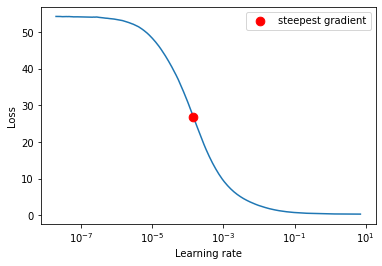

'\nbatch size = 16\ncel0 weight = 1\ncel0_mu = 0.001 lr = [1e-6, 1] best_lr = 1e-4\ncel0_mu = 0.01 lr = [1e-6, 1] best_lr = 1e-4\n\nklnc_a = 200 weight = 1 [1e-6,1e-1] best=1e-4\nklnc_a = 100 weight = 1\nklnc_a = 150 weight = 1\n\nklnc_a = 150 weight = 0.1 [1e-6, 1e-1] best=1e-4\n             weight = 0.001\n\n\n\n\n\n\n'

In [5]:

# lr_finder = LRFinder(cnn, optimizer, criterion, device="cuda")
# lr_finder.range_test(training_generator, end_lr=100, num_iter=300)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

lr_finder = LRFinder(model, optimizer, calc_loss, device="cuda")
lr_finder.range_test(training_generator, start_lr=1e-8, end_lr=10, num_iter=300, step_mode="exp")
lr_finder.plot(log_lr=True)
lr_finder.reset()

"""
batch size = 1
cel0 weight = 1
cel0_mu = 0.001 lr = [1e-6, 1] best_lr = 1e-4
cel0_mu = 0.01 lr = [1e-6, 1] best_lr = 1e-4

klnc_a = 200 weight = 1 [1e-6,1e-1] best=1e-4
klnc_a = 100 weight = 1
klnc_a = 150 weight = 1

klnc_a = 150 weight = 0.1 [1e-6, 1e-1] best=1e-4
             weight = 0.001

batch_size  = 8
el0_mu = 0.001 lr = [1e-6, 1] best_lr = 1e-4

"""